# Explore here

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definimos el preprocesamiento (escalado de 0-255 a 0-1)
trdata = ImageDataGenerator(rescale=1./255)
tsdata = ImageDataGenerator(rescale=1./255)

# Cargamos las imágenes desde la carpeta organizada
train_generator = trdata.flow_from_directory(
    directory=os.path.join('/workspaces/DeepLearning_LeandroR093/data_processed', 'train'),
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

test_generator = tsdata.flow_from_directory(
    directory=os.path.join('/workspaces/DeepLearning_LeandroR093/data_processed', 'test'),
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

Found 20000 images belonging to 2 classes.


Found 5000 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Cargar la base de VGG16 pre-entrenada
# include_top=False elimina las capas pesadas de 4096 neuronas que bloqueaban tu Kernel
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# 2. Congelar la base para no re-entrenarla (ahorra RAM y tiempo)
base_model.trainable = False

# 3. Crear el modelo nuevo encima de la base
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5), # Para evitar que el modelo memorice (overfitting)
    Dense(2, activation='softmax') # 2 clases: Perro y Gato
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() 

2026-02-25 15:47:42.847281: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,434,050 (74.14 MB)

 Trainable params: 4,719,362 (18.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Callbacks para guardar el mejor modelo y parar si deja de mejorar
checkpoint = ModelCheckpoint("vgg16_transfer_learning.keras", 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=20,  # En lugar de 100 (Reduces el tiempo un 80%)
    epochs=5,            # Con 5 épocas suele ser suficiente para notar aprendizaje
    validation_data=test_generator,
    validation_steps=10, # Evaluación rápida
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5


2026-02-25 15:47:45.583887: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.
2026-02-25 15:47:46.029925: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.


 1/20 ━━━━━━━━━━━━━━━━━━━━ 3:53 12s/step - accuracy: 0.6562 - loss: 0.8668

2026-02-25 15:47:56.254864: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.
2026-02-25 15:47:56.444080: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.


 2/20 ━━━━━━━━━━━━━━━━━━━━ 3:01 10s/step - accuracy: 0.5938 - loss: 0.9857

2026-02-25 15:48:06.341539: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 327680000 exceeds 10% of free system memory.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5954 - loss: 0.8294
Epoch 1: val_accuracy improved from None to 0.81875, saving model to vgg16_transfer_learning.keras

Epoch 1: finished saving model to vgg16_transfer_learning.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 294s 15s/step - accuracy: 0.6828 - loss: 0.6445 - val_accuracy: 0.8188 - val_loss: 0.4128
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8071 - loss: 0.4077 
Epoch 2: val_accuracy did not improve from 0.81875
20/20 ━━━━━━━━━━━━━━━━━━━━ 320s 16s/step - accuracy: 0.7937 - loss: 0.4185 - val_accuracy: 0.8156 - val_loss: 0.3750
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8422 - loss: 0.3694 
Epoch 3: val_accuracy improved from 0.81875 to 0.88750, saving model to vgg16_transfer_learning.keras

Epoch 3: finished saving model to vgg16_transfer_learning.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 322s 16s/step - accuracy: 0.8375 - loss: 0.3757 - val_accuracy: 0.8875 - val_loss: 0.2995
Epoch 4/5
20/20 ━━━━━━━━━━

✅ Modelo cargado exitosamente.


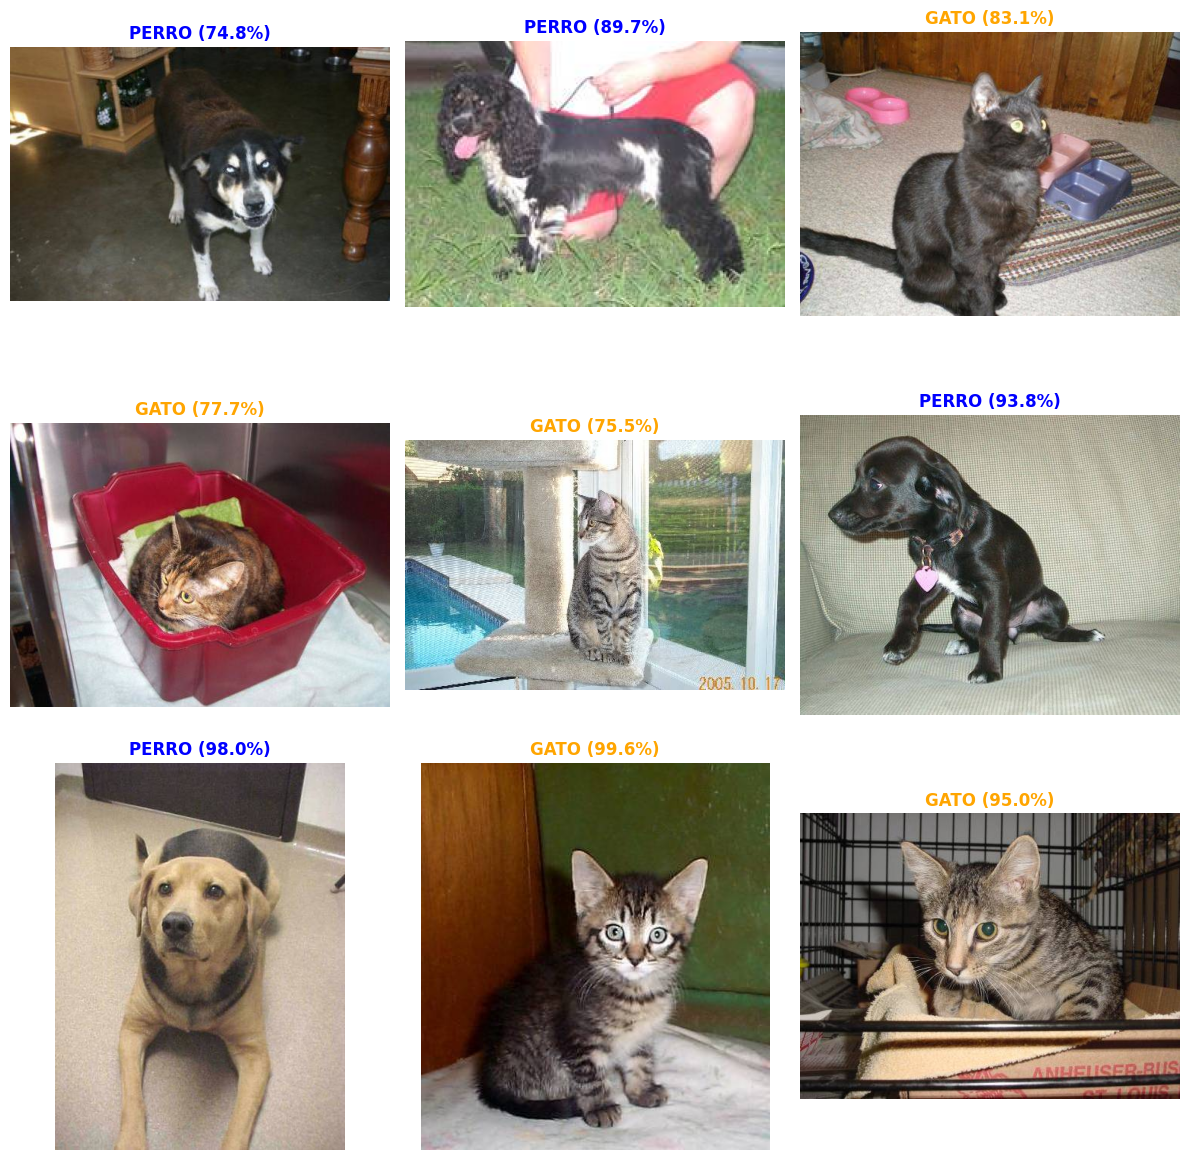

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 1. CARGAR EL MODELO (Asegúrate de que el nombre del archivo coincida con el que guardaste)
# Usamos el nombre del archivo que generó el Checkpoint o el save manual
model_path = 'vgg16_transfer_learning.keras' 

if os.path.exists(model_path):
    best_model = load_model(model_path)
    print("✅ Modelo cargado exitosamente.")
else:
    print(f"❌ No se encontró el archivo {model_path}. Verifica el nombre.")

# 2. CONFIGURAR RUTAS
test_dir = '/workspaces/DeepLearning_LeandroR093/data_processed/test'
all_test_files = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            all_test_files.append(os.path.join(root, file))

# 3. SELECCIONAR 9 IMÁGENES AL AZAR Y PREDECIR
if len(all_test_files) >= 9:
    random_pics = random.sample(all_test_files, 9)
    plt.figure(figsize=(12, 12))

    for i, img_path in enumerate(random_pics):
        # Cargar para mostrar
        img_visual = mpimg.imread(img_path)
        
        # Preprocesar para el modelo
        img_for_model = image.load_img(img_path, target_size=(200, 200))
        img_array = image.img_to_array(img_for_model)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        
        # Predicción
        prediction = best_model.predict(img_array, verbose=0)
        
        # Etiqueta (0: Cat, 1: Dog según el orden alfabético de las carpetas)
        if prediction[0][0] > prediction[0][1]:
            label = f"GATO ({prediction[0][0]:.1%})"
            color = 'orange'
        else:
            label = f"PERRO ({prediction[0][1]:.1%})"
            color = 'blue'
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_visual)
        plt.title(label, color=color, fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes imágenes en la carpeta de test.")

In [7]:
model.save('dogs_cats_classifier.keras')

In [8]:
from tensorflow.keras.models import load_model
loaded_model = load_model('dogs_cats_classifier.keras')

pocas_imagenes_steps = 20 

print("Calculando precisión en una muestra del set de prueba...")
test_loss, test_acc = loaded_model.evaluate(test_generator, steps=pocas_imagenes_steps)

print(f'\n✅ Precisión del modelo cargado (muestra): {test_acc:.2f}')



Calculando precisión en una muestra del set de prueba...
 1/20 ━━━━━━━━━━━━━━━━━━━━ 3:35 11s/step - accuracy: 0.8438 - loss: 0.3635

20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.8703 - loss: 0.3142

✅ Precisión del modelo cargado (muestra): 0.87


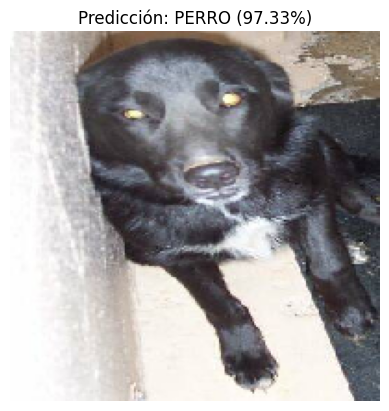

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Usar la ruta de la imagen que quieres probar
test_image_path = '/workspaces/DeepLearning_LeandroR093/data_processed/test/dog/dog.10000.jpg'

# 2. Cargar y procesar (Asegúrate de ejecutar esta celda completa)
img = image.load_img(test_image_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# 3. PREDICCIÓN (Cambiado de 'reconstructed_model' a 'loaded_model')
prediction = loaded_model.predict(img_array, verbose=0)

# 4. Lógica de etiquetas
if prediction[0][0] > prediction[0][1]:
    animal = "GATO"
    confianza = prediction[0][0]
else:
    animal = "PERRO"
    confianza = prediction[0][1]

# 5. Visualizar
plt.imshow(img)
plt.title(f"Predicción: {animal} ({confianza:.2%})")
plt.axis('off')
plt.show()

In [13]:
import os
print("Archivos en la raíz:", os.listdir('.'))
# Si tienes carpeta src, mira qué hay dentro
if os.path.exists('src'):
    print("Archivos en src:", os.listdir('src'))

Archivos en la raíz: ['utils.py', 'data_processed', 'app.py', 'explore.ipynb', 'dogs_cats_classifier.keras', 'dataset', 'vgg16_transfer_learning.keras']
